# Pre/post plot
Compares the consumption before and after a project was completed.<br>
Includes plots that range from Jan-Dec as well as plots in terms of # months before and after project completion

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import datetime as dt

In [10]:
#Behavior of datetime objects
a = dt.datetime.strptime('6/24/17', '%m/%d/%y')
b = dt.datetime.strptime('4/26/17', '%m/%d/%y')
b-a

datetime.timedelta(days=-59)

In [11]:
#Returns true if the project was completed during this record, false if not
def binarize(series):
    return series['PlanYear']<series['YearShift']
#Same function, but using charge date and completed date rather than year
def binarize1(series):
    return series['StatusDate']<series['ChargeDateShift']
#Same function using only 12 months before/after
def binarize2(series):
    a =  series['StatusDate']
    b = series['ChargeDateShift']
    if abs((b-a).days)<365:
        return float(a<b)
    else:
        return np.nan
#using count of months after/before instead of Jan, Feb, etc. 
def prepost(series):
    a =  series['StatusDate']
    b = series['ChargeDateShift']
    #Return the signed number of months between the charge date and the completed date
    if abs((b-a).days)<365:
        return (b.year - a.year) * 12 + b.month - a.month
    else:
        return np.nan
#Apply both the below functions to shift the charge date back one month (See Weatherization.ipynb for justification)
def shift_y(series):
    if series['Month'] == 1:
        return series['Year']-1
    else:
        return series['Year']
def shift_m(series):
    if series['Month'] == 1:
        return 12
    else:
        return series['Month']-1
#Convert MY to date
def toDateMY(series):
    y = series['YearShift']
    m = series['MonthShift']
    days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]
    days_per_month_ly =[31,29,31,30,31,30,31,31,30,31,30,31]
    if y%4 == 0:
        d = days_per_month_ly[int(m)-1]
    else:
        d = days_per_month[int(m)-1]
    return dt.datetime.strptime(""+str(int(series['YearShift']))+"-"+str(int(series['MonthShift']))+"-"+str(d), '%Y-%m-%d')
def toDate2(series):
    return dt.datetime.strptime(series, '%m/%d/%y')


In [16]:
#Plot
def prepostchart(df1, df2, col, servicetype):
    plt.plot(df1.index, df1[col], label='Post-project') #post
    plt.plot(df2.index, df2[col], label='Pre-project') #pre
    
    plt.legend(loc='upper right')
    if servicetype == 'RELC':
        plt.title('Mean Electricity Consumption per Month')
        plt.ylabel("Mean KWH per SqFt")
    else:
        plt.title('Mean Gas Consumption per Month')
        plt.ylabel("Mean CCF per SqFt")
    plt.xlabel("Time")
    plt.xticks(np.arange(13), ('','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec'))
    plt.savefig(servicetype+'.png')
    plt.show()

## First, using only plan year from orignal data set

In [17]:

df = pd.read_csv("/home/mirabel/Dropbox (GaTech)/CDS-2019-AlbanyHub/subsets of utilities/rep_rehab_utilities_sqft.csv")
df['YearShift'] = df[['Year', 'Month']].apply(shift_y, axis=1)
df['MonthShift'] = df[['Year', 'Month']].apply(shift_m, axis=1)

sr = df[['MonthShift', 'YearShift', 'Address','ServiceType', 'PlanYear', 'ConsumptionPerSQFT']].copy()
df = sr.groupby(by=['YearShift', 'MonthShift', 'ServiceType', 'Address', 'PlanYear']).sum().reset_index()
df['projectCompleted'] = df[['YearShift', 'PlanYear']].apply(binarize, axis=1)

In [18]:
#Inspect -> true if charge year was during or after year, false if before
df.loc[12000:12010, :]

,YearShift,MonthShift,ServiceType,Address,PlanYear,ConsumptionPerSQFT,projectCompleted
12000,2014,2,RGAS,405 VINTAGE RD,2016,0.047115,False
12001,2014,2,RGAS,408 ALICE AVE,2008,0.102011,True
12002,2014,2,RGAS,411 BONNY VIEW AVE,2016,0.055016,False
12003,2014,2,RGAS,412 ROSSER LN,2008,0.000000,True
12004,2014,2,RGAS,413 LOUIS AVE,2011,0.000000,True
12005,2014,2,RGAS,413 MULBERRY AVE,2017,0.029435,False
12006,2014,2,RGAS,416 ROSSER LN,2010,0.039352,True
12007,2014,2,RGAS,420 BONNY VIEW AVE,2015,0.012346,False
12008,2014,2,RGAS,421 DORSETT AVE,2008,0.078367,True
12009,2014,2,RGAS,423 ODOM AVE,2010,0.096269,True


In [13]:
df_e_t = df[(df['ServiceType']=='RELC')&(df['projectCompleted']==1)]
df_e_f = df[(df['ServiceType']=='RELC')&(df['projectCompleted']==0)]

df_g_t = df[(df['ServiceType']=='RGAS')&(df['projectCompleted']==1)]
df_g_f = df[(df['ServiceType']=='RGAS')&(df['projectCompleted']==0)]

#Elec
df1 = df_e_t.groupby(by='MonthShift').mean()
df2 = df_e_f.groupby(by='MonthShift').mean()
#Gas
dfa = df_g_t.groupby(by='MonthShift').mean()
dfb = df_g_f.groupby(by='MonthShift').mean()
#prepostchart(df1, df2, 'Consumption', 'RELC')

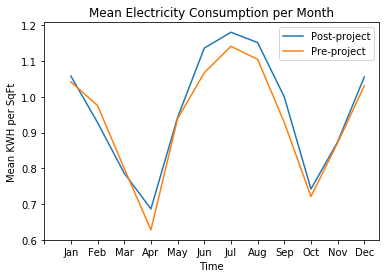

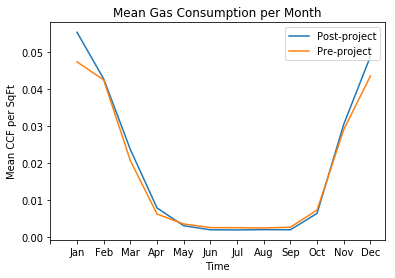

In [26]:
prepostchart(df1, df2, 'ConsumptionPerSQFT', 'RELC')

prepostchart(dfa, dfb, 'ConsumptionPerSQFT', 'RGAS')

In [27]:
print("Gas: pvalue=",stats.ttest_rel(dfa['ConsumptionPerSQFT'], dfb['ConsumptionPerSQFT']).pvalue)

Gas: pvalue= 0.13100275288586008


In [28]:
print("Elec: pvalue=",stats.ttest_rel(df1['ConsumptionPerSQFT'], df2['ConsumptionPerSQFT']).pvalue)

Elec: pvalue= 0.035467078796732145


In [60]:
df['Address'].nunique()

280

## Instead, by completed date and charge date

In [29]:

df = pd.read_csv("/home/mirabel/Dropbox (GaTech)/CDS-2019-AlbanyHub/subsets of utilities/rep_rehab_utilities_sqft.csv")
df['YearShift'] = df[['Year', 'Month']].apply(shift_y, axis=1)
df['MonthShift'] = df[['Year', 'Month']].apply(shift_m, axis=1)

#group by month, year, address, type
sr = df[['YearShift', 'MonthShift', 'ServiceType', 'Address','StatusDate', 'ConsumptionPerSQFT']].copy()
df = sr.groupby(by=['YearShift', 'MonthShift', 'ServiceType', 'Address', 'StatusDate']).sum().reset_index()
df['ChargeDateShift'] = df[['YearShift', 'MonthShift']].apply(toDateMY, axis=1)
df['StatusDate'] = df['StatusDate'].apply(toDate2)
df['projectCompleted'] = df[['StatusDate', 'ChargeDateShift']].apply(binarize1, axis=1)

In [30]:
df_e_t = df[(df['ServiceType']=='RELC')&(df['projectCompleted']==1)]
df_e_f = df[(df['ServiceType']=='RELC')&(df['projectCompleted']==0)]

df_g_t = df[(df['ServiceType']=='RGAS')&(df['projectCompleted']==1)]
df_g_f = df[(df['ServiceType']=='RGAS')&(df['projectCompleted']==0)]

#Elec
df1 = df_e_t.groupby(by='MonthShift').mean()
df2 = df_e_f.groupby(by='MonthShift').mean()
#Gas
dfa = df_g_t.groupby(by='MonthShift').mean()
dfb = df_g_f.groupby(by='MonthShift').mean()
#prepostchart(df1, df2, 'Consumption', 'RELC')

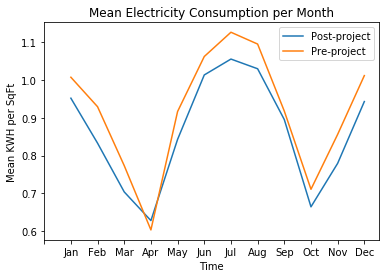

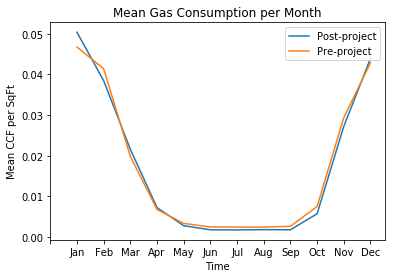

In [31]:
prepostchart(df1, df2, 'ConsumptionPerSQFT', 'RELC')

prepostchart(dfa, dfb, 'ConsumptionPerSQFT', 'RGAS')

In [32]:
print("Gas: pvalue=",stats.ttest_rel(dfa['ConsumptionPerSQFT'], dfb['ConsumptionPerSQFT']).pvalue)

Gas: pvalue= 0.5927422020427756


In [33]:
print("Elec: pvalue=",stats.ttest_rel(df1['ConsumptionPerSQFT'], df2['ConsumptionPerSQFT']).pvalue)

Elec: pvalue= 7.022855483844299e-05


## On a 0-11 scale, months before and months after

In [34]:

df = pd.read_csv("/home/mirabel/Dropbox (GaTech)/CDS-2019-AlbanyHub/subsets of utilities/rep_rehab_utilities_sqft.csv")
df['YearShift'] = df[['Year', 'Month']].apply(shift_y, axis=1)
df['MonthShift'] = df[['Year', 'Month']].apply(shift_m, axis=1)

#group by month, year, address, type
sr = df[['YearShift', 'MonthShift', 'ServiceType', 'Address','StatusDate', 'ConsumptionPerSQFT']].copy()
df = sr.groupby(by=['YearShift', 'MonthShift', 'ServiceType', 'Address', 'StatusDate']).sum().reset_index()
df['ChargeDateShift'] = df[['YearShift', 'MonthShift']].apply(toDateMY, axis=1)
df['StatusDate'] = df['StatusDate'].apply(toDate2)
df['projectCompleted'] = df[['StatusDate', 'ChargeDateShift']].apply(prepost, axis=1)

In [35]:
df_e_t = df[(df['ServiceType']=='RELC')&(df['projectCompleted']>=0)]
df_e_f = df[(df['ServiceType']=='RELC')&(df['projectCompleted']<0)]

df_g_t = df[(df['ServiceType']=='RGAS')&(df['projectCompleted']>=0)]
df_g_f = df[(df['ServiceType']=='RGAS')&(df['projectCompleted']<0)]
#elec
df1 = df_e_t.groupby(by='projectCompleted').mean()
df2 = df_e_f.groupby(by='projectCompleted').mean()
df2.index = range(11, -1, -1)
#gas
dfa = df_g_t.groupby(by='projectCompleted').mean()
dfb = df_g_f.groupby(by='projectCompleted').mean()
dfb.index = range(11, -1, -1)

In [36]:
def prepostchart2(df1, df2, col, servicetype):
    plt.plot(df1.index, df1[col], label='Post-project') #post
    plt.plot(df2.index, df2[col], label='Pre-project') #pre
    
    plt.legend(loc='upper right')
    if servicetype == 'RELC':
        plt.title('Mean Electricity Consumption per Month')
        plt.ylabel("Mean KWH per SqFt")
    else:
        plt.title('Mean Gas Consumption per Month')
        plt.ylabel("Mean CCF per SqFt")
    plt.xlabel("Time")
    #plt.xticks(np.arange(13), range(0, 12))
    plt.savefig(servicetype+'-Num.png')
    plt.show()


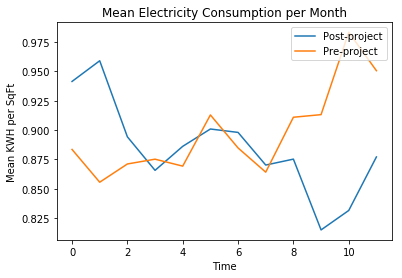

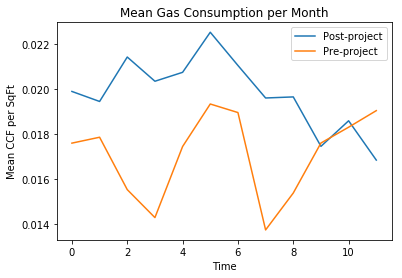

In [37]:
#likely needs weatherization to work properly
prepostchart2(df1, df2, 'ConsumptionPerSQFT', 'RELC')

prepostchart2(dfa, dfb, 'ConsumptionPerSQFT', 'RGAS')